In [2]:
from IPython.display import clear_output
!pip install transformers datasets
!pip install googletrans==3.1.0a0
clear_output()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !cp "/content/drive/MyDrive/AI/AppStore/AppleStore.csv" .
# !cp "/content/drive/MyDrive/APP/appall_description_new.fth" .
!cp "/content/drive/MyDrive/APP/appall_description_nostops_en.fth" .
!cp "/content/drive/MyDrive/APP/xy_stops.txt" .
!cp "/content/drive/MyDrive/APP/app_model/sentence_vectors.pkl" .

cp: cannot stat '/content/drive/MyDrive/APP/app_model/sentence_vectors.pkl': No such file or directory


In [4]:
from googletrans import Translator
import pandas as pd

def trans_chinese(text):
    translator = Translator()
    return translator.translate(text, dest = 'zh-tw').text

# appstore = pd.read_csv("/content/AppleStore.csv").iloc[:,1:]
description = pd.read_feather("/content/appall_description_nostops_en.fth")

In [5]:
description.shape

(743689, 7)

In [6]:
description.head()

,package_name,app_name,genre_old,comments,summary,description,app_brief
0,app.web.moneymanager,Money Manager,"""FINANCE""",,Money management can be intimidating. Fortunat...,Manage your money with all-in-one software,money manager finance money management intimid...
1,app.webserveis.appmanager,App Manager,"""TOOLS""",Great app! I use it more than I thought I woul...,strong It is not necessary that you have root...,App manager is a powerful application for mana...,app manager tools strong rooted device remove...
2,app.willa,Willa,"""PRODUCTIVITY""",,We know you love pretty things and want to be ...,Simple expense tracking,willa productivity love pretty things top fina...
3,app.wise.caracceleration,Car Acceleration Meter,"""TOOLS""",It sucked. I was out at 7am for the cooler air...,Turn your android phone into a car acceleratio...,Measure 0-100 acceleration time simply using y...,car acceleration meter tools turn android phon...
4,app.words.boost,Words Boost,"""EDUCATION""",,Increase your vocabulary with Words Boost. T...,Learn over 540 intellectual words that will he...,words boost education increase vocabulary wor...


### Sentence Embedding

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from dataclasses import dataclass
import numpy as np
import pickle

@dataclass
class SentenceEmbedder:

    model_ckpt:str = "sentence-transformers/all-MiniLM-L6-v2"

    def __post_init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_ckpt)
        self.model = AutoModel.from_pretrained(self.model_ckpt)

        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)


    def _embed(self, sentences):
        encoder_input = self.tokenizer(sentences, padding = True, truncation = True, return_tensors = 'pt').to(self.device)

        with torch.no_grad():
            model_output = self.model(**encoder_input)

        token_embeddings = model_output.last_hidden_state

        return encoder_input, model_output

    def mean_pooling(self, encoder_input, model_output):

        attention_mask = encoder_input['attention_mask']

        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        )
        sentence_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min = 1e-9)
        sentence_embeddings = F.normalize(sentence_embeddings, p = 2, dim = 1)
        return sentence_embeddings

    def embed_sentences(self, sentences):
        encoder_input, model_output = self._embed(sentences)
        return self.mean_pooling(encoder_input, model_output).cpu().numpy()

    def __call__(self, sentences, batch_size = 512, breakpoint = 0):

        n_batchs = len(sentences) // batch_size + int(len(sentences) % batch_size > 0)

        subset_embeddings = []

        for i in range(breakpoint, n_batchs):
            print("Embedding Batch: {}".format(i + 1), end = "......")
            subset = sentences[i * batch_size: (i+1) * batch_size]
            subset_embedding = self.embed_sentences(subset)
            subset_embeddings.append(subset_embedding)
            first_name = '/content/drive/MyDrive/APP/app_model/sentence_vectors'
            last_name = first_name + str(breakpoint) + '.pkl'
            with open(last_name,'wb') as f:
              pickle.dump(np.concatenate(subset_embeddings), f)
            print("Done.")

        return np.concatenate(subset_embeddings)

In [8]:
sentences = description.app_brief.tolist()
embedder = SentenceEmbedder()
embeded_sentences = embedder(sentences,batch_size = 256, breakpoint=0)

Embedding Batch: 1......

KeyboardInterrupt: ignored

In [ ]:
import pickle
with open('/content/drive/MyDrive/APP/app_model/sentence_vectors.pkl','wb') as f:
    pickle.dump(embeded_sentences, f)

with open('/content/drive/MyDrive/APP/app_model/sentence_vectors.pkl','rb') as f:
    sentence_vectors = pickle.load(f)

clear_output()
print("Embedding Finished...")

In [ ]:
import pickle
with open('/content/sentence_vectors.pkl','rb') as f:
    sentence_vectors = pickle.load(f)

### TSNE visualization

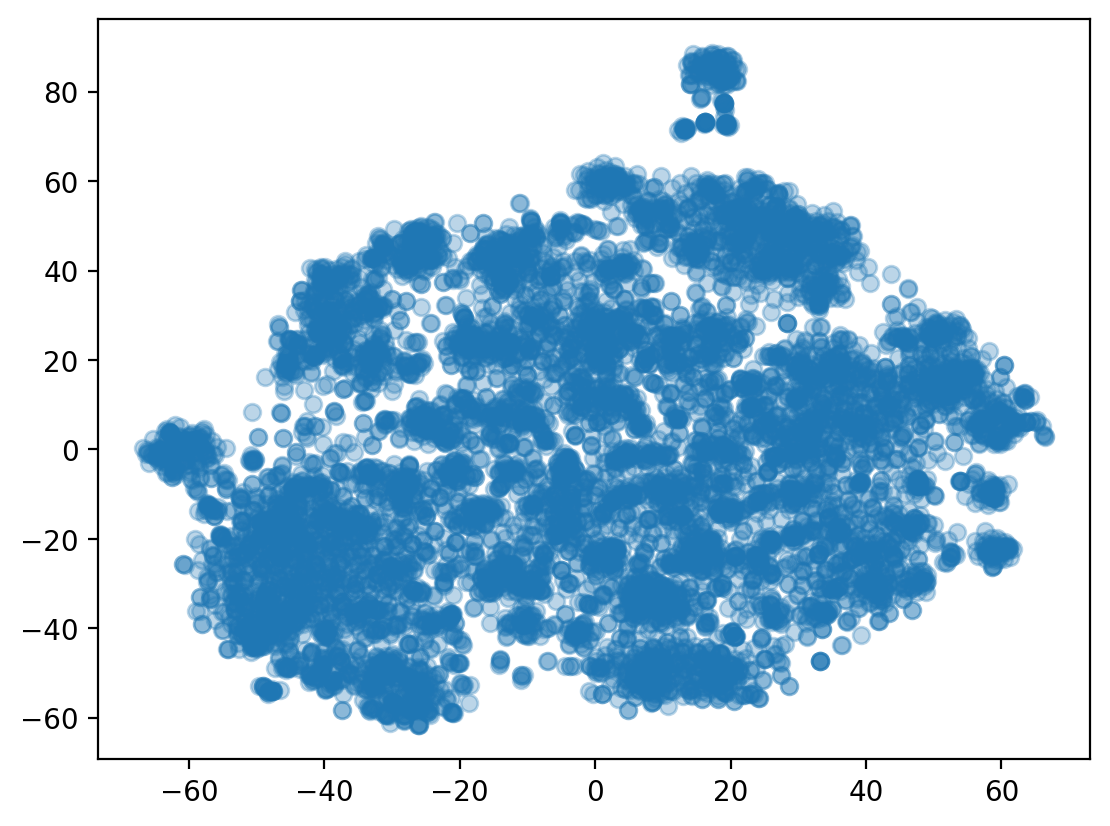

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%config InlineBackend.figure_format = 'retina'

visual_vectors = sentence_vectors[np.random.choice(sentence_vectors.shape[0],10000),:]

embeddings = visual_vectors

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity = 50, random_state=42, metric = 'cosine')
vis_dims = tsne.fit_transform(embeddings)

plt.scatter(vis_dims[:,0], vis_dims[:,1], alpha = 0.3)
plt.show()

### Document Clustering

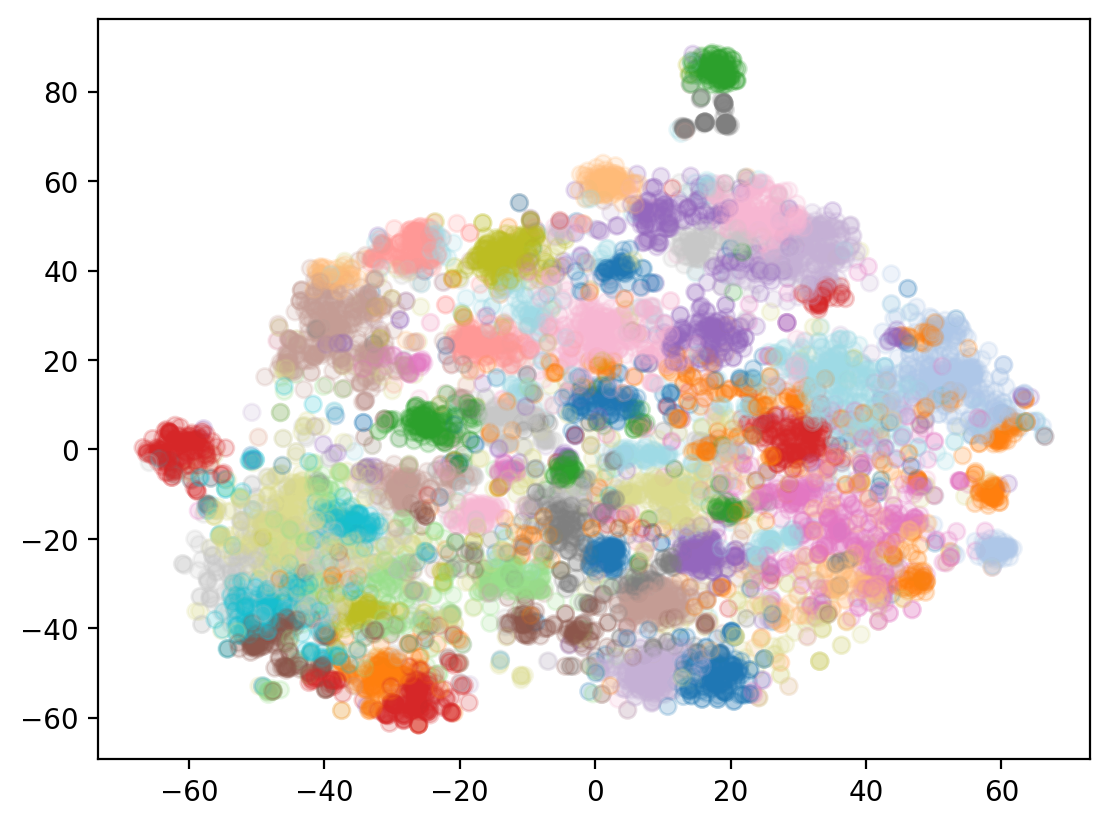

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=50,n_init = 'auto',random_state = 42)
model.fit(visual_vectors)
labels = model.labels_
plt.scatter(vis_dims[:,0], vis_dims[:,1],c = labels,cmap ='tab20', alpha = 0.2)
plt.show()

In [ ]:
for l in range(50):
    s = np.array(sentences)[np.where(labels == l)[0]]
    print(f"【{l}】", trans_chinese(s[0][:100]).replace("\n",'||'))

【0】 描述||利用你的錢||幾秒鐘內向世界上幾乎任何地方匯款或在線支付
【1】 你會成為什麼樣的神？仁慈還是報復？玩掌上上帝並找到答案
【2】 超過 300 萬次下載！||||武裝我的主！粉碎城堡現在可在 iPhone 和 iPod 上使用
【3】 StickWars 是一款快節奏、動作豐富的遊戲，需要閃電般的手指和巧妙的策略
【4】 經營一家遊戲公司，並以百萬點擊率為目標。||||它是一個大大增強的版本，配備了內部硬件開發和工作變更系統。||||尋找並培訓優秀的員工。||員工成長過程中可以製作的遊戲類型
【5】 Tumblr 是一個發現和發布你喜歡的東西，並加入喜歡的人社區的地方
【6】 一次相遇||一段故事||一個全新的開始||優酷 這世界很酷|| ||《擇天記》星霜之下逆勢擇天  馬上上優酷 看獨家解讀||《人民的名義》實力派演員吹響反貪集結號，史上最大尺度反腐劇亮劍打虎||《大明王朝1566》
【7】 ** iPray for Mac OS X 已過期 **||||*********************************************||** 消息||**||** 古蘭經
【8】 ■ 每月用戶超過6000萬・擁有255萬份食譜的美食搜索服務■||||◆ 適合這類人的完美烹飪應用程序||・我想讓每天的菜單決定更容易||・我想擴大我的飯菜範圍||・從現在開始我想盡我所能自己做飯
【9】 概述||||入侵開始！品脫大小的士兵正在襲擊你的國家 - 你有什麼
【10】 Juxtaposer 可讓您快速輕鬆地將多張圖片組合成創意有趣的蒙太奇照片
【11】 eBay 應用程序是找到您需要的任何東西的最佳方式，從連衣裙、手提包到時尚配飾
【12】 與朋友聯繫。玩文字遊戲。與幾乎任何人一起玩 SCRABBLE 遊戲 - 或者玩
【13】 LDW 團隊祝您節日快樂！||||Virtual Families 是一款休閒的家庭模擬遊戲，可在真實環境中運行
【14】 VLC Remote® 可讓您遠程控制 Mac 或 PC 上的 VLC 媒體播放器。支持iPhone, iPa
【15】 與袖珍版和 PC 版的 Minecraft 兼容！ （無需額外費用！）||||皮膚 Pro Cr
【16】 ***特價：短時間 0.99 美元！如果您一直在等待獲取完整版，現在是

### Cluster Checking

In [ ]:
cluster_id = 40 #@param {'type':'integer'}
n_samples = 5 #@param {'type':'integer'}
s = np.array(sentences)[np.where(labels == cluster_id)[0]]
for sent in s[:n_samples]:
    print(trans_chinese(sent))
    print("-"*200)
    print("-"*200)
    print("-"*200)

棒球賽季又回來了，Yahoo Sports 是跟踪每個球場的最佳方式。

查看 Yahoo Sports 提供的所有內容：

• 收藏夾
登錄並設置您最喜歡的球隊，以在您自己的個性化新聞流中獲取賽程、比賽亮點和更新。

• 運動的
隨時了解您關注的所有比分、統計數據和聯賽。

• 頭條新聞
從 Adrian Wojnarowski、Dan Wetzel 和 Pat Forde 等作家那裡獲取獨家內容以及體育界最重要的頭條新聞。

• 警報
為您最喜愛的球隊設置提醒，並在您需要時收到通知。關注每場得分比賽或僅在比賽開始時關注。你的選擇。

• 現場比賽
免費觀看數百場現場直播的 MLB 和 NHL 比賽。無需訂閱。

包含在雅虎體育中：
- MLB：觀看數百場免費直播 MLB 比賽
- NFL：比分、亮點、突發新聞和統計數據
- 大學橄欖球、大學籃球、大學女籃
- NBA、WNBA：比分、亮點、突發新聞和統計數據
- NHL：觀看數百場免費直播 NHL 比賽
- 足球：
 - 英超聯賽，二級聯賽，一級聯賽，冠軍，蘇格蘭超級聯賽，足總杯，聯賽杯，
 - 歐洲冠軍聯賽、歐洲聯賽、美洲杯、
 - Ligue 1, Coupe de la Ligue, Coupe de France, Tropee des Champions, Ligue 2,
 - 德甲，德國超級杯，DFB Pokal，
 - MLS、俄羅斯超級聯賽、Eredivisie、巴西甲級聯賽、
 - 意大利甲級聯賽、意大利杯、乙級聯賽、
 - 西甲、國王杯、西乙、西班牙超級杯
 - 高爾夫 - PGA、LPGA、PGA Champions、PGA Web.com、PGA European、
 - 賽車 - NASCAR Sprint、NASCAR Xfinity、IndyCar、Formula 1
 - 綜合格鬥
 - 網球 - 男子網球、女子網球

讓 Yahoo Sports 成為您的專屬：
1. 使用您的 Yahoo 帳戶登錄以獲得跨所有設備的最佳體驗
2. 為您最喜歡的球隊和聯賽加註星標，以獲取有關您想要的運動的個性化新聞和更新
3. 為您最喜歡的球隊設置提醒，以便您在需要時收到通知。
4. 從 Adrian Wojnarowski、Dan Wetzel 和 Pat Forde 等作家那裡獲取獨家內容。